# Multi-Period Optimal Power Flow
This notebook is inspired by Chapters 6 and 7 of the following book:<br>
Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.<br> <br>
The following notebook:<br>
https://github.com/Power-Systems-Optimization-Course/power-systems-optimization/blob/master/Notebooks/06-Optimal-Power-Flow.ipynb<br><br>
And the following papers:<br>
Li F, Bo R. Small test systems for power system economic studies. InIEEE PES general meeting 2010 Jul 25 (pp. 1-4). IEEE.<br>
Ordoudis C, Pinson P, Morales JM, Zugno M. An updated version of the IEEE RTS 24-bus system for electricity market and power system operation studies. Technical University of Denmark. 2016;13

In [1]:
using JuMP
using DataFrames
using Plots
using Ipopt
using FStrings
using GLPK

**Problem Description:**<br>
Optimal Power Flow (OPF) is an optimization problem where the goal is to find steady state operating conditions for power plants connected to a transmission network, while meeting demands and minimizing opeartional costs. We will start with a single period DC power flow problem, and gradually add more complexity to the problem.

# 1. Single Period Optimal DC Power Flow
For a two-bus power network as shown in the figure, the optimization problem is as characterized as follows:<br>
<figure>
<img src="src/2Bus_OPF.png" style="width:60%">
<figcaption align = "center"> A 2-bus network [1] </figcaption>
</figure>

**Mathematical representation:** <br>
$$
\underset{P_{g}, \delta_{i}}{min} \; \sum_{g_{1},g_{2}}^{} b_{g}P_{g}
$$
$$
P_{ij} = \frac {\delta_{1}-\delta_{2}} {X_{12}}
$$

$$
P_{g1} = P_{12}
$$
$$
P_{g2} + P_{12} = L_{2}
$$
$$
-P_{12}^{max} \le P_{12} \le P_{12}^{max}
$$
$$
\delta_{1} = 0 \; Slack
$$
Other parameters related to this DC-OPF are as follows:<br>
$L_{2} = 400 MW$<br>
$X_{12} = 0.2 pu$<br>
$P_{12}^{max} = 1.5 pu$<br>
And the characteristics of the two gas generators are provided in the following table [1]:

In [2]:
dc_df = DataFrame();
dc_df[!, :g] = ["g1", "g2"]
dc_df[!, :a_g] = [3., 4.05]
dc_df[!, :b_g] = [20., 18.07]
dc_df[!, :c_g] = [100, 98.87]
dc_df[!, :P_min] = [28, 90]
dc_df[!, :P_max] = [206, 284]
dc_df

Row,g,a_g,b_g,c_g,P_min,P_max
,String,Float64,Float64,Float64,Int64,Int64
1,g1,3.0,20.0,100.0,28,206
2,g2,4.05,18.07,98.87,90,284


In [3]:
Base.@kwdef mutable struct model_options_2bus
        slack::Int = 1                     # Slack bus index
        g::Int = 2                         # Nmber of gas generators
        a::Vector{Float64}                 # Gas generator cost coefficient
        b::Vector{Float64}                 # Gas generator cost coefficient
        c::Vector{Float64}                 # Gas generator cost coefficient
        P_min::Vector{Float64}             # Gas generator power lower bound
        P_max::Vector{Float64}             # Gas generator power upper bound
        L2::Float64 = 400                  # Demand at bus number 2
        X12::Float64 = 0.2                 # Line reactance between buses 1 and 2
        Pmax12::Float64 = 1.5              # Line flow limit between buses 1 and 2
        Sbase::Float64 = 100               # Power base in MVA
end

model_options_2bus

In [4]:
function build_model(opt::model_options_2bus)

    model = Model(Ipopt.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, P[g_=1:opt.g] >=0);     #Generator Power Output
    @variable(model, P12);                   #Power flow between buses 1 and 2
    @variable(model, delta[g_=1:opt.g]);     #Generator voltage angle

    #Expressions
    #Fuel cost
    ex_FC = @expression(model, FC[g_= 1:opt.g], (opt.a[g_] * P[g_]^2 + opt.b[g_] * P[g_] + opt.c[g_]) );

    #Constraints
    c_generation_LB = @constraint(model, [g_=1:opt.g], P[g_] >= opt.P_min[g_] / opt.Sbase);
    c_generation_UB = @constraint(model, [g_=1:opt.g], P[g_] <= opt.P_max[g_] / opt.Sbase);

    c_reactance = @constraint(model, P12 == (delta[1] - delta[2]) / opt.X12);
    c_bus1 = @constraint(model, P[1] == P12);
    c_bus2 = @constraint(model, P[2] + P12 == opt.L2 / opt.Sbase);
    c_slack_angle = @constraint(model, delta[opt.slack] == 0);
    c_edge_flow_LB = @constraint(model, P12 >= -opt.Pmax12);
    c_edge_flow_UB = @constraint(model, P12 <= opt.Pmax12);

    #Objective Function
    @objective(model, Min, sum(FC[:]));
    
    return model
end

build_model (generic function with 1 method)

In [5]:
model_options_base = model_options_2bus(a=dc_df[!, :a_g], b=dc_df[!, :b_g], c=dc_df[!, :c_g], P_min=dc_df[!, :P_min], 
    P_max=dc_df[!, :P_max]);

model = build_model(model_options_base);
optimize!(model)

println("Total operating cost is \$", objective_value(model))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Total operating cost is $306.1074998627072


# 1.1 Three-Bus Network DC-OPF
The general form of DC-OPF with multiple buses can be denoted as follows [1]:<br>
**Mathematical representation:**<br>
$$
\underset{P_{g}, \delta_{i}}{min} \; \sum_{g \in \Omega_{G}}^{} b_{g}P_{g}
$$
$$
P_{ij} = \frac {\delta_{i}-\delta_{j}} {X_{ij}} \; \; ij \in \Omega_{l}
$$

$$
\sum_{g \in \Omega_{G}^{i}}^{} P_{g} - L_{i} = \sum_{j \in \Omega_{l}^{i}}^{} P_{ij} : \lambda_{i} \; \; i \in \Omega_{B}
$$
$$
-P_{ij}^{max} \le P_{ij} \le P_{ij}^{max} \; \; ij \in \Omega_{l}
$$
$$
P_{g}^{min} \le P_{g} \le P_{g}^{max}
$$
For a three-bus network shown in the following figure, the characteristics of the two gas generators and the network are provided in the following table [2]:
<figure>
<img src="src/3Bus_OPF.png" style="width:60%">
<figcaption align = "center"> A 3-bus network [2] </figcaption>
</figure>

In [6]:
bus_df3 = DataFrame();
bus_df3[!, :bus] = ["bus1", "bus2", "bus3"]
bus_df3[!, :omega_g] = [[1], [2], []]
bus_df3[!, :demands] = [0.,0.,600.]
bus_df3[!, :connectivity] = [[1,2],[0,2],[0,1]]
bus_df3[!, :x] = [[1e10,0.0281,0.0281],[0.0281,1e10,0.0281],[0.0281,0.0281,1e10]]
bus_df3[!, :limit] = [[0,500,500],[500,0,500],[500,500,0]]
bus_df3

Row,bus,omega_g,demands,connectivity,x,limit
,String,Array…,Float64,Array…,Array…,Array…
1,bus1,Any[1],0.0,"[1, 2]","[1.0e10, 0.0281, 0.0281]","[0, 500, 500]"
2,bus2,Any[2],0.0,"[0, 2]","[0.0281, 1.0e10, 0.0281]","[500, 0, 500]"
3,bus3,Any[],600.0,"[0, 1]","[0.0281, 0.0281, 1.0e10]","[500, 500, 0]"


In [7]:
gen_df3 = DataFrame();
gen_df3[!, :Gen] = ["g1", "g2", "g3"]
gen_df3[!, :b_g] = [50., 100.,  0.]
gen_df3[!, :P_min] = [0., 0., 0.]
gen_df3[!, :P_max] = [1000., 1000., 0.]
gen_df3

Row,Gen,b_g,P_min,P_max
,String,Float64,Float64,Float64
1,g1,50.0,0.0,1000.0
2,g2,100.0,0.0,1000.0
3,g3,0.0,0.0,0.0


In [8]:
Base.@kwdef mutable struct model_options_nbus
        nb::Int                               # Number of buses
        slack::Int = 1                        # Slack bus index
        g::Int = 2                            # Nmber of gas generators
        Sbase::Float64 = 100                  # Power base in MVA
        b::Vector{Float64}                    # Gas generator cost coefficient
        P_min::Vector{Float64}                # Gas generator power lower bound
        P_max::Vector{Float64}                # Gas generator power upper bound
        omega_g::Vector{Vector{Int}}          # List of generators connected to each bus
        L::Vector{Float64}                    # Load at each bus
        X::Vector{Vector{Float64}}            # Reactance value for each edge
        edge_limit::Vector{Vector{Float64}}   # Power flow limit for each edge
end

model_options_nbus

In [9]:
function build_model_nbus(opt::model_options_nbus)

    model = Model(GLPK.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, Pg[g_=1:opt.g] >=0);                       #Generator Power Output
    @variable(model, P[n_=1:opt.nb, b_=1:opt.nb]);              #Power flow between buses
    @variable(model, delta[b_=1:opt.nb]);                       #Bus voltage angle

    #Expressions
    #Fuel cost
    ex_FC = @expression(model, FC[g_= 1:opt.g], (opt.b[g_] * Pg[g_] * opt.Sbase) );

    #Constraints
    c_generation_LB = @constraint(model, [g_=1:opt.g], Pg[g_] >= opt.P_min[g_] / opt.Sbase);
    c_generation_UB = @constraint(model, [g_=1:opt.g], Pg[g_] <= opt.P_max[g_] / opt.Sbase);

    c_reactance = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb], P[b_,n_] == (delta[b_] - delta[n_]) / opt.X[b_][n_]);
    c_slack_angle = @constraint(model, delta[opt.slack] == 0);
    c_edge_flow_LB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb], P[b_, n_] >= -opt.edge_limit[b_][n_] / opt.Sbase);
    c_edge_flow_UB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb], P[b_, n_] <= opt.edge_limit[b_][n_] / opt.Sbase);
    c_bus_balance = @constraint(model, [b_=1:opt.nb], opt.L[b_] / opt.Sbase == sum(P[b_,:]) + sum(Pg[f] for f in opt.omega_g[b_]));


    #Objective Function
    @objective(model, Min, sum(FC[:]));
    
    return model
end

build_model_nbus (generic function with 1 method)

In [10]:
model_options_3bus = model_options_nbus(nb=3, slack=3, g=3, b=gen_df3[!, :b_g], P_min=gen_df3[!, :P_min], P_max=gen_df3[!, :P_max], 
    omega_g=bus_df3[!, :omega_g], L=bus_df3[!, :demands], X=bus_df3[!, :x], edge_limit=bus_df3[!, :limit]);

model = build_model_nbus(model_options_3bus);
optimize!(model)

In [11]:
println("Total operating cost is \$", objective_value(model))

Total operating cost is $30000.0


In [12]:
results_df3 = DataFrame();
results_df3[!, :Bus] = bus_df3[!, :bus];
results_df3[!, Symbol("Pg (MW)")] = value.(model[:Pg]) .* model_options_3bus.Sbase;
results_df3[!, Symbol("Delta (rad)")] = value.(model[:delta]);
results_df3[!, Symbol("L (MW)")] = model_options_3bus.L;
results_df3[!, Symbol("LMP")] .= NaN;

**LMP:** <br>
LMP at each node is defined as follows:<br>
If the demand at a node is increased by 1MW, how much does the cost at that node increse in terms of $/h.

In [13]:
old_cost = objective_value(model)
for b_ in 1:model_options_3bus.nb
    model_options_3bus.L[b_] += 1
    model = build_model_nbus(model_options_3bus);
    optimize!(model)
    new_cost = objective_value(model)
    results_df3[b_,:LMP] = new_cost-old_cost
    model_options_3bus.L[b_] -= 1
end
results_df3

Row,Bus,Pg (MW),Delta (rad),L (MW),LMP
,String,Float64,Float64,Float64,Float64
1,bus1,600.0,-0.1124,0.0,50.0
2,bus2,0.0,-0.0562,0.0,50.0
3,bus3,0.0,0.0,600.0,50.0


# 1.2 Five-Bus Network DC-OPF
Similar to a 3-Bus network, we can solve the DC-OPF for a 5-Bus network. Consider the following PJM 5-bus network [3]:
<figure>
<img src="src/5Bus_OPF.png" style="width:60%">
<figcaption align = "center"> PJM 5-bus network [3] </figcaption>
</figure>
The characteristics of the two gas generators and the network are provided in the following tables[3]:

In [14]:
bus_df5 = DataFrame()
bus_df5[!, :bus] = ["bus1", "bus2", "bus3", "bus4", "bus5"]
bus_df5[!, :omega_g] = [[1,2], [],[3], [4], [5]]
bus_df5[!, :demands] = [0, 300, 300, 400, 0]
bus_df5[!, :connectivity] = [["bus2","bus4","bus5"],["bus1","bus3"],["bus2","bus4"],["bus1","bus3","bus5"],["bus1","bus4"]]
bus_df5[!, :x] = [[1e10,0.0281,1e10,0.0304,0.0064],[0.0281,1e10,0.0108,1e10,1e10],[1e10,0.0108,1e10,0.0297,1e10], 
                [0.0304,1e10,0.0297,1e10,0.0297],[0.0064,1e10,1e10,0.0297,1e10]]
bus_df5[!, :limit] = [[0,400,0,1e10,1e10],[400,0,1e10,0,0],[0,1e10,0,1e10,0],[1e10,0,1e10,0,240],[1e10,0,0,240,0]]
bus_df5

Row,bus,omega_g,demands,connectivity,x,limit
,String,Array…,Int64,Array…,Array…,Array…
1,bus1,"Any[1, 2]",0,"[""bus2"", ""bus4"", ""bus5""]","[1.0e10, 0.0281, 1.0e10, 0.0304, 0.0064]","[0.0, 400.0, 0.0, 1.0e10, 1.0e10]"
2,bus2,Any[],300,"[""bus1"", ""bus3""]","[0.0281, 1.0e10, 0.0108, 1.0e10, 1.0e10]","[400.0, 0.0, 1.0e10, 0.0, 0.0]"
3,bus3,Any[3],300,"[""bus2"", ""bus4""]","[1.0e10, 0.0108, 1.0e10, 0.0297, 1.0e10]","[0.0, 1.0e10, 0.0, 1.0e10, 0.0]"
4,bus4,Any[4],400,"[""bus1"", ""bus3"", ""bus5""]","[0.0304, 1.0e10, 0.0297, 1.0e10, 0.0297]","[1.0e10, 0.0, 1.0e10, 0.0, 240.0]"
5,bus5,Any[5],0,"[""bus1"", ""bus4""]","[0.0064, 1.0e10, 1.0e10, 0.0297, 1.0e10]","[1.0e10, 0.0, 0.0, 240.0, 0.0]"


In [15]:
gen_df5 = DataFrame()
gen_df5[!, :Gen] = ["g1", "g2", "g3", "g4", "g5"]
gen_df5[!, :b_g] = [14., 15.,  30., 40., 10.]
gen_df5[!, :P_min] = [0., 0., 0., 0., 0.]
gen_df5[!, :P_max] = [40., 170., 520., 200., 600.]

gen_df5

Row,Gen,b_g,P_min,P_max
,String,Float64,Float64,Float64
1,g1,14.0,0.0,40.0
2,g2,15.0,0.0,170.0
3,g3,30.0,0.0,520.0
4,g4,40.0,0.0,200.0
5,g5,10.0,0.0,600.0


In [16]:
model_options_5bus = model_options_nbus(nb=nrow(bus_df5), slack=1, g=nrow(gen_df5), b=gen_df5[!, :b_g], P_min=gen_df5[!, :P_min], 
    P_max=gen_df5[!, :P_max], omega_g=bus_df5[!, :omega_g], L=bus_df5[!, :demands], X=bus_df5[!, :x], edge_limit=bus_df5[!, :limit]);

model = build_model_nbus(model_options_5bus);
optimize!(model)

In [17]:
println("Total operating cost is \$", objective_value(model))

Total operating cost is $17479.896925344685


In [18]:
results_df5 = DataFrame();
results_df5[!, :Bus] = bus_df5[!, :bus];
results_df5[!, Symbol("Pg (MW)")] = [[round(value.(model[:Pg][f]) * model_options_5bus.Sbase , digits=1) 
        for f in bus_df5[!, :omega_g][b_]] for b_ in 1:model_options_5bus.nb]
# results_df5[!, Symbol("Pg (MW)")] = value.(model[:Pg]) .* model_options_5bus.Sbase;
results_df5[!, Symbol("Delta (rad)")] = round.(value.(model[:delta]), digits=2);
results_df5[!, Symbol("L (MW)")] = model_options_5bus.L;
results_df5[!, Symbol("LMP")] .= NaN;

In [19]:
old_cost = objective_value(model)
for b_ in 1:model_options_5bus.nb
    model_options_5bus.L[b_] += 1
    model = build_model_nbus(model_options_5bus);
    optimize!(model)
    new_cost = objective_value(model)
    results_df5[b_,:LMP] = round(new_cost-old_cost, digits=1)
    model_options_5bus.L[b_] -= 1
end
results_df5

Row,Bus,Pg (MW),Delta (rad),L (MW),LMP
,String,Vector,Float64,Float64,Float64
1,bus1,"[40.0, 170.0]",-0.0,0.0,17.0
2,bus2,Any[],0.07,300.0,26.4
3,bus3,[323.5],0.06,300.0,30.0
4,bus4,[0.0],0.06,400.0,39.9
5,bus5,[466.5],-0.01,0.0,10.0


# 1.3 IEEE Reliability Test System (RTS) 24-bus network
The RTS 24-bus network is shown below, wit hthe slack bus being bus 13 and Sbase being 100 MVA [4]. 
<figure>
<img src="src/24Bus_OPF.png" style="width:60%">
<figcaption align = "center"> Single-line diagram of IEEE-RTS 24-bus network [4] </figcaption>
</figure>
The specifications of the network are provided in the following tables [1]:

In [20]:
bus_df24 = DataFrame()
bus_df24[!, :bus] = ["bus1", "bus2", "bus3", "bus4", "bus5", "bus6", "bus7", "bus8", "bus9", 
                  "bus10", "bus11", "bus12", "bus13", "bus14", "bus15", "bus16", "bus17", 
                  "bus18", "bus19", "bus20", "bus21", "bus22", "bus23", "bus24"]
bus_df24[!, :omega_g] = [[3], [4], [], [], [], [], [9], [], [], [], [], [], [10], [], [5,11], [6], 
                [], [1], [], [], [2], [12], [7,8], []]
bus_df24[!, :demands] = [108, 97, 180, 74, 71, 136, 125, 171, 175, 195, 0, 0, 265, 194, 317, 
                      100, 0, 333, 181, 128, 0, 0, 0, 0]
bus_df24[!, :x] = [[1e10,0.0139,0.2112,1e10,0.0845,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [0.0139,1e10,1e10,0.1267,1e10,0.1920,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [0.2112,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.1190,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839], 
                    [1e10,0.1267,1e10,1e10,1e10,1e10,1e10,1e10,0.1037,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [0.0845,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0883,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,0.1920,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0605,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0614,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,0.0614,1e10,0.1651,0.1651,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,0.1190,0.1037,1e10,1e10,1e10,0.1651,1e10,1e10,0.0839,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,0.0883,0.0605,1e10,0.1651,1e10,1e10,0.0839,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839,0.0839,1e10,1e10,0.0476,0.0418,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0839,0.0839,1e10,1e10,0.0476,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0966,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0476,0.0476,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0865,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0418,1e10,1e10,1e10,1e10,0.0389,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0173,1e10,1e10,1e10,1e10,0.0245,1e10,1e10,0.0519], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0389,0.0173,1e10,0.0259,1e10,0.0231,1e10,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0259,1e10,0.0144,1e10,1e10,1e10,0.1053,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0144,1e10,1e10,1e10,0.0130,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0231,1e10,1e10,1e10,0.0198,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0198,1e10,1e10,1e10,0.0108,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0245,1e10,1e10,0.0130,1e10,1e10,1e10,0.0678,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.1053,1e10,1e10,1e10,0.0678,1e10,1e10,1e10], 
                    [1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0966,0.0865,1e10,1e10,1e10,1e10,1e10,1e10,0.0108,1e10,1e10,1e10,1e10], 
                    [1e10,1e10,0.0839,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,0.0519,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10,1e10]]
bus_df24[!, :limit] = [[0,175.,175.,0,175,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [175.,0,0,175.,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [175.,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,400.], 
                    [0,175.,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [175.,0,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,175.,0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,0,0,0,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,0,0,175.,0,175.,175.,0,0,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,175.,175.,0,0,0,175.,0,0,400.,400.,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,175.,175.,0,175.,0,0,400.,400.,0,0,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,0,0,0,0,400.,400.,0,0,500.,500.,0,0,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,0,0,0,0,400.,400.,0,0,500.,0,0,0,0,0,0,0,0,0,500.,0], 
                    [0,0,0,0,0,0,0,0,0,0,500.,500.,0,0,0,0,0,0,0,0,0,0,500.,0], 
                    [0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,500.,0,0,0,0,0,0,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,1000.,0,0,500.], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,500.,500.,0,500.,0,500.,0,0,0,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,500.,0,0,0,500.,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,1000.,0,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,1000.,0,0,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000.,0,0,0,1000.,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1000.,0,0,1000.,0,0,0,500.,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,500.,0,0,0], 
                    [0,0,0,0,0,0,0,0,0,0,0,500.,500.,0,0,0,0,0,0,1000.,0,0,0,0], 
                    [0,0,400.,0,0,0,0,0,0,0,0,0,0,0,500.,0,0,0,0,0,0,0,0,0]]
first(bus_df24,5)

Row,bus,omega_g,demands,x,limit
,String,Array…,Int64,Array…,Array…
1,bus1,Any[3],108,"[1.0e10, 0.0139, 0.2112, 1.0e10, 0.0845, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[0.0, 175.0, 175.0, 0.0, 175.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
2,bus2,Any[4],97,"[0.0139, 1.0e10, 1.0e10, 0.1267, 1.0e10, 0.192, 1.0e10, 1.0e10, 1.0e10, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[175.0, 0.0, 0.0, 175.0, 0.0, 175.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
3,bus3,Any[],180,"[0.2112, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.119, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.0839]","[175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 400.0]"
4,bus4,Any[],74,"[1.0e10, 0.1267, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.1037, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[0.0, 175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,bus5,Any[],71,"[0.0845, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.0883 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


In [21]:
gen_df24 = DataFrame()
gen_df24[!, :Gen] = ["g1", "g2", "g3", "g4", "g5", "g6", "g7", "g8", "g9", "g10", "g11", "g12"]
gen_df24[!, :b_g] = [5.47, 5.47,  13.32, 13.32, 16., 10.52, 10.52, 10.89, 20.7, 20.93, 26.11, 0.]
gen_df24[!, :P_min] = [100., 100., 30.4, 30.4, 54.25, 54.25, 108.5, 140, 75, 206.85, 12, 0.]
gen_df24[!, :P_max] = [400., 400., 152., 152., 155., 155., 310., 350., 350., 591., 60., 300.]
gen_df24[!, :RU] = [47., 47., 14., 14., 21., 21., 21., 28., 49., 21., 7., 35.]
gen_df24[!, :RD] = [47., 47., 14., 14., 21., 21., 21., 28., 49., 21., 7., 35.]
gen_df24

Row,Gen,b_g,P_min,P_max,RU,RD
,String,Float64,Float64,Float64,Float64,Float64
1,g1,5.47,100.0,400.0,47.0,47.0
2,g2,5.47,100.0,400.0,47.0,47.0
3,g3,13.32,30.4,152.0,14.0,14.0
4,g4,13.32,30.4,152.0,14.0,14.0
5,g5,16.0,54.25,155.0,21.0,21.0
6,g6,10.52,54.25,155.0,21.0,21.0
7,g7,10.52,108.5,310.0,21.0,21.0
8,g8,10.89,140.0,350.0,28.0,28.0
9,g9,20.7,75.0,350.0,49.0,49.0


# 1.3.1 IEEE RTS network, base case
In the base case, we assume all generators and all transmission lines are working properly. The solution for the base case is given as follows:

In [22]:
model_options_24bus = model_options_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), b=gen_df24[!, :b_g], P_min=gen_df24[!, :P_min], 
    P_max=gen_df24[!, :P_max], omega_g=bus_df24[!, :omega_g], L=bus_df24[!, :demands], X=bus_df24[!, :x], edge_limit=bus_df24[!, :limit]);

model = build_model_nbus(model_options_24bus);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $29574.275501411532


In [23]:
results_df24 = DataFrame();
results_df24[!, :Bus] = bus_df24[!, :bus];
results_df24[!, Symbol("Pg (MW)")] = [[round(value.(model[:Pg][f]) * model_options_24bus.Sbase , digits=1) 
        for f in bus_df24[!, :omega_g][b_]] for b_ in 1:model_options_24bus.nb]
results_df24[!, Symbol("Delta (rad)")] = round.(value.(model[:delta]), digits=2);
results_df24[!, Symbol("L (MW)")] = model_options_24bus.L;
results_df24[!, Symbol("LMP")] .= NaN;

old_cost = objective_value(model)
for b_ in 1:model_options_24bus.nb
    model_options_24bus.L[b_] += 1
    model = build_model_nbus(model_options_24bus);
    optimize!(model)
    new_cost = objective_value(model)
    results_df24[b_,:LMP] = round(new_cost-old_cost, digits=1)
    model_options_24bus.L[b_] -= 1
end
first(results_df24,5)

Row,Bus,Pg (MW),Delta (rad),L (MW),LMP
,String,Vector,Float64,Float64,Float64
1,bus1,[152.0],0.15,108.0,20.7
2,bus2,[152.0],0.15,97.0,20.7
3,bus3,Any[],0.11,180.0,20.7
4,bus4,Any[],0.19,74.0,20.7
5,bus5,Any[],0.19,71.0,20.7


# 1.3.1 IEEE RTS network, branch flow limit case
In this case, we assume the branch flow limits are reduced by 30% and solve the DC-OPF for the network. the results are as follows [1]:

In [24]:
model_options_24bus_bfl = model_options_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), b=gen_df24[!, :b_g], P_min=gen_df24[!, :P_min], 
    P_max=gen_df24[!, :P_max], omega_g=bus_df24[!, :omega_g], L=bus_df24[!, :demands], X=bus_df24[!, :x], 
    edge_limit=deepcopy(bus_df24)[!, :limit] .* 0.7);

model = build_model_nbus(model_options_24bus_bfl);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $29747.72484123788


In [25]:
results_df24bfl = DataFrame();
results_df24bfl[!, :Bus] = bus_df24[!, :bus];
results_df24bfl[!, Symbol("Pg (MW)")] = [[round(value.(model[:Pg][f]) * model_options_24bus_bfl.Sbase , digits=1) 
        for f in bus_df24[!, :omega_g][b_]] for b_ in 1:model_options_24bus.nb]
results_df24bfl[!, Symbol("Delta (rad)")] = round.(value.(model[:delta]), digits=2);
results_df24bfl[!, Symbol("L (MW)")] = model_options_24bus_bfl.L;
results_df24bfl[!, Symbol("LMP")] .= NaN;

old_cost = objective_value(model)
for b_ in 1:model_options_24bus_bfl.nb
    model_options_24bus_bfl.L[b_] += 1
    model = build_model_nbus(model_options_24bus_bfl);
    optimize!(model)
    new_cost = objective_value(model)
    results_df24bfl[b_,:LMP] = round(new_cost-old_cost, digits=1)
    model_options_24bus_bfl.L[b_] -= 1
end
first(results_df24bfl,5)

Row,Bus,Pg (MW),Delta (rad),L (MW),LMP
,String,Vector,Float64,Float64,Float64
1,bus1,[152.0],0.16,108.0,20.7
2,bus2,[152.0],0.16,97.0,20.7
3,bus3,Any[],0.13,180.0,19.1
4,bus4,Any[],0.2,74.0,20.8
5,bus5,Any[],0.2,71.0,21.0


# 1.3.1 IEEE RTS network, branch outage
In this case, we consider cases where some of the branches would experience an outage and observe that effect on the network. Here are 3 scenarios [1]:<br>
- **Scenario 1:** branches $l_{20-19}$, $l_{12-23}$ are out.
- **Scenario 2:** branches $l_{14-16}$, $l_{16-19}$ are out.
- **Scenario 3:** branches $l_{1-5}$, $l_{4-2}$ are out.

In [26]:
model_options_24bus_bfl_scn1 = model_options_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), b=gen_df24[!, :b_g], 
    P_min=gen_df24[!, :P_min], P_max=gen_df24[!, :P_max], omega_g=bus_df24[!, :omega_g], L=bus_df24[!, :demands], X=bus_df24[!, :x], 
    edge_limit=deepcopy(bus_df24)[!, :limit]);

model = build_model_nbus(model_options_24bus_bfl_scn1);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $29574.275501411532


**Scenario 1:** The following solution suggests this scenario doesn't have a feasible solution:

In [27]:
model_options_24bus_bfl_scn1.edge_limit[19][20] = 0.
model_options_24bus_bfl_scn1.edge_limit[20][19] = 0.
model_options_24bus_bfl_scn1.edge_limit[12][23] = 0.
model_options_24bus_bfl_scn1.edge_limit[23][12] = 0.


model = build_model_nbus(model_options_24bus_bfl_scn1);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $434689.62086274615


In [28]:
is_solved_and_feasible(model)

false

**Scenario 2:** The following solution suggests this scenario doesn't have a feasible solution:

In [29]:
model_options_24bus_bfl_scn2 = model_options_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), b=gen_df24[!, :b_g], 
    P_min=gen_df24[!, :P_min], P_max=gen_df24[!, :P_max], omega_g=bus_df24[!, :omega_g], L=bus_df24[!, :demands], X=bus_df24[!, :x], 
    edge_limit=deepcopy(bus_df24)[!, :limit]);

model_options_24bus_bfl_scn2.edge_limit[14][16] = 0.
model_options_24bus_bfl_scn2.edge_limit[16][14] = 0.
model_options_24bus_bfl_scn2.edge_limit[16][19] = 0.
model_options_24bus_bfl_scn2.edge_limit[19][16] = 0.


model = build_model_nbus(model_options_24bus_bfl_scn2);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $700983.4899170835


In [30]:
is_solved_and_feasible(model)

false

**Scenario 3:** The following solution suggests this scenario has a feasible solution:

In [31]:
model_options_24bus_bfl_scn3 = model_options_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), b=gen_df24[!, :b_g], 
    P_min=gen_df24[!, :P_min], P_max=gen_df24[!, :P_max], omega_g=bus_df24[!, :omega_g], L=bus_df24[!, :demands], X=bus_df24[!, :x], 
    edge_limit=deepcopy(bus_df24)[!, :limit]);

model_options_24bus_bfl_scn2.edge_limit[1][5] = 0.
model_options_24bus_bfl_scn2.edge_limit[5][1] = 0.
model_options_24bus_bfl_scn2.edge_limit[4][2] = 0.
model_options_24bus_bfl_scn2.edge_limit[2][4] = 0.


model = build_model_nbus(model_options_24bus_bfl_scn3);
optimize!(model)

println("Total operating cost is \$", objective_value(model))

Total operating cost is $29574.275501411532


In [32]:
is_solved_and_feasible(model)

true

# 1.4 Multi-period optimal DC-OPF with wind
In this case we consider a DC-OPF with wind, over a 24-hour period. We also consider load shedding for buses. The mathematical representation of the problem is shown in the following:<br>
**Mathematical representation:**<br>
$$
\underset{}{min} \ OF = \sum_{g,t}^{} b_{g}P_{g,t} + \sum_{i,t}^{} Cls \times {LS}_{i,t} + Ccrt \times P_{i,t}^{wc}
$$
$$
\sum_{g \in \Omega_{G}^{i}}^{} P_{g,t} + {LS}_{i,t} + P_{i,t}^{w} - L_{i,t} = \sum_{j \in \Omega_{l}^{i}}^{} P_{ij,t} : \lambda_{i,t}
$$
$$
P_{ij,t} = \frac {\delta_{i,t}-\delta_{j,t}} {X_{ij}} \; \; ij \in \Omega_{l}
$$

$$
-P_{ij}^{max} \le P_{ij,t} \le P_{ij}^{max} \; \; ij \in \Omega_{l}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
0 \le {LS}_{i,t} \le L_{i,t}
$$
$$
P_{i,t}^{wc} = w_{t} \Lambda_{i}^{t} - P_{i,t}^{w}
$$
$$
0 \le P_{i,t}^{w} \le w_{t} \Lambda_{i}^{t}
$$
where $Cls$ is the load shedding cost, $LS$ is the amount of load shedding at each bus, $Ccrt$ is the cost of wind curtailment, $P^{wc}$ is the amount of wind curtailment, $\Omega_{G}$ is the set of generators connected to a bus, $\Omega_{l}$ are the edges of the network,  $\Lambda$ is wind availability, and $w$ is the nameplate capacity of a wind generator.

In [33]:
Base.@kwdef mutable struct model_options_wind_nbus_mp
        nb::Int                               # Number of buses
        slack::Int = 1                        # Slack bus index
        g::Int = 12                           # Nmber of gas generators
        wg::Int = 3                           # Nmber of wind generators
        t::Int = 24                           # Power Flow time horizon in hours
        Sbase::Float64 = 100                  # Power base in MVA
        b::Vector{Float64}                    # Gas generator cost coefficient
        RU::Vector{Float64}                   # Gas generator ramp-up rate
        RD::Vector{Float64}                   # Gas generator ramp-down rate
        P_min::Vector{Float64}                # Gas generator power lower bound
        P_max::Vector{Float64}                # Gas generator power upper bound
        WP_max::Vector{Float64}               # Wind generator power upper bound
        omega_g::Vector{Vector{Int}}          # List of gas generators connected to each bus
        omega_wg::Vector{Vector{Int}}         # List of wind generators connected to each bus
        L::Vector{Float64}                    # Total daily load at each bus
        L_pct::Vector{Float64}                # Percentage of daily load at each time step
        X::Vector{Vector{Float64}}            # Reactance value for each edge
        edge_limit::Vector{Vector{Float64}}   # Power flow limit for each edge
        W::Vector{Float64}                    # Wind availability at each time step
        Cls::Float64                          # Cost of load shedding
        Ccrt::Float64                         # Cost of wind curtailment
end

model_options_wind_nbus_mp

In [34]:
function build_model_wind_nbus(opt::model_options_wind_nbus_mp)

    model = Model(GLPK.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, Pg[g_=1:opt.g, t_=1:opt.t] >=0);                  #Generator power output
    @variable(model, P[n_=1:opt.nb, b_=1:opt.nb, t_=1:opt.t]);         #Power flow between buses
    @variable(model, delta[b_=1:opt.nb, t_=1:opt.t]);                  #Bus voltage angle
    @variable(model, Lsh[b_=1:opt.nb, t_=1:opt.t] >=0);                #Bus load shedding
    @variable(model, Pw[wg_=1:opt.wg, t_=1:opt.t] >=0);                #Wind generator power output
    @variable(model, Pwc[wg_=1:opt.wg, t_=1:opt.t] >=0);               #Wind generator power curtailment

    #Expressions
    ex_FC = @expression(model, FC[g_= 1:opt.g, t_=1:opt.t], (opt.b[g_] * Pg[g_,t_] * opt.Sbase) );          #Fuel cost
    ex_LSHC = @expression(model, LSHC[b_= 1:opt.nb, t_=1:opt.t], (opt.Cls * Lsh[b_,t_] * opt.Sbase) );      #Load shedding cost
    ex_WCC = @expression(model, WCC[wg_= 1:opt.wg, t_=1:opt.t], (opt.Ccrt * Pwc[wg_,t_] * opt.Sbase) );     #Wind curtailment cost

    #Constraints
    c_generation_LB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Pg[g_,t_] >= opt.P_min[g_] / opt.Sbase);      #Generator min output constraint
    c_generation_UB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Pg[g_,t_] <= opt.P_max[g_] / opt.Sbase);      #Generator max output constraint
    c_ramp_up = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Pg[g_,t_] - Pg[g_,t_-1]) <= opt.RU[g_] / opt.Sbase);     #Generator ramp-up constraint
    c_ramp_down = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Pg[g_,t_-1] - Pg[g_,t_]) <= opt.RD[g_] / opt.Sbase);   #Generator ramp-down constraint

    c_reactance = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_,n_,t_] == (delta[b_,t_] - delta[n_,t_]) / opt.X[b_][n_]);
    c_slack_angle = @constraint(model, [t_=1:opt.t], delta[opt.slack,t_] == 0);
    c_edge_flow_LB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_, n_, t_] >= -opt.edge_limit[b_][n_] / opt.Sbase);
    c_edge_flow_UB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_, n_, t_] <= opt.edge_limit[b_][n_] / opt.Sbase);
    c_load_shedding = @constraint(model, [b_=1:opt.nb, t_=1:opt.t], Lsh[b_,t_] <= (opt.L[b_] * opt.L_pct[t_]) / opt.Sbase);
    c_wc_balance = @constraint(model, [wg_=1:opt.wg, t_=1:opt.t], Pwc[wg_,t_] + Pw[wg_,t_] == (opt.WP_max[wg_] / opt.Sbase) * opt.W[t_]);
    c_wgen_limit = @constraint(model, [wg_=1:opt.wg, t_=1:opt.t], Pw[wg_,t_] <= (opt.WP_max[wg_] / opt.Sbase) * opt.W[t_]);
    c_bus_balance = @constraint(model, [b_=1:opt.nb, t_=1:opt.t], (opt.L[b_] * opt.L_pct[t_]) / opt.Sbase == -sum(P[b_,:,t_]) + 
        sum(Pg[f,t_] for f in opt.omega_g[b_]) + Lsh[b_,t_] + sum(Pw[f,t_] for f in opt.omega_wg[b_]) );


    #Objective Function
    @objective(model, Min, (sum(FC[:,:]) + sum(LSHC[:,:]) + sum(WCC[:,:])) );
    
    return model
end

build_model_wind_nbus (generic function with 1 method)

In [35]:
avlblty = [0.079, 0.087, 0.117, 0.259, 0.361, 0.56, 0.65, 0.56, 0.5, 0.548, 0.76, 0.71, 0.87, 0.91, 0.96, 1., 
           0.87, 0.65, 0.64, 0.561, 0.565, 0.556, 0.724, 0.84];
demand_pcts = [0.685, 0.644, 0.613, 0.599, 0.589, 0.6, 0.63, 0.65, 0.7, 0.787, 0.84, 0.85, 0.86, 0.83, 0.81, 0.815, 
              0.87, 1., 0.99, 0.936, 0.888, 0.809, 0.746, 0.733];
wg_df = DataFrame()
wg_df[!, :wg] = ["wg1", "wg2", "wg3"]
wg_df[!, :cap] = [200., 150., 100.]
wg_df

Row,wg,cap
,String,Float64
1,wg1,200.0
2,wg2,150.0
3,wg3,100.0


In [36]:
bus_df24[!, :wind_gen] = [[], [], [], [], [], [], [], [1], [], [], [], [], [], [], [], [], [], [], [2], [], [3], [], [], []]
first(bus_df24,5)

Row,bus,omega_g,demands,x,limit,wind_gen
,String,Array…,Int64,Array…,Array…,Array…
1,bus1,Any[3],108,"[1.0e10, 0.0139, 0.2112, 1.0e10, 0.0845, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[0.0, 175.0, 175.0, 0.0, 175.0, 0.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Any[]
2,bus2,Any[4],97,"[0.0139, 1.0e10, 1.0e10, 0.1267, 1.0e10, 0.192, 1.0e10, 1.0e10, 1.0e10, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[175.0, 0.0, 0.0, 175.0, 0.0, 175.0, 0.0, 0.0, 0.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Any[]
3,bus3,Any[],180,"[0.2112, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.119, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.0839]","[175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 400.0]",Any[]
4,bus4,Any[],74,"[1.0e10, 0.1267, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.1037, 1.0e10 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[0.0, 175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0, 0.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Any[]
5,bus5,Any[],71,"[0.0845, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 0.0883 … 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10, 1.0e10]","[175.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 175.0 … 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Any[]


In [37]:
model_options_wind_24bus = model_options_wind_nbus_mp(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), wg=nrow(wg_df), t=24, 
    b=gen_df24[!, :b_g], RU=gen_df24[!, :RU], RD=gen_df24[!, :RD], P_min=gen_df24[!, :P_min], P_max=gen_df24[!, :P_max], 
    WP_max=wg_df[!, :cap], omega_g=bus_df24[!, :omega_g], omega_wg=bus_df24[!, :wind_gen], L=bus_df24[!, :demands], L_pct=demand_pcts,
    X=bus_df24[!, :x], edge_limit=bus_df24[!, :limit], W=avlblty, Cls=10000, Ccrt=50);

model = build_model_wind_nbus(model_options_wind_24bus);
optimize!(model)

println("Total operating cost is \$", round(objective_value(model), digits=2))

Total operating cost is $434218.72


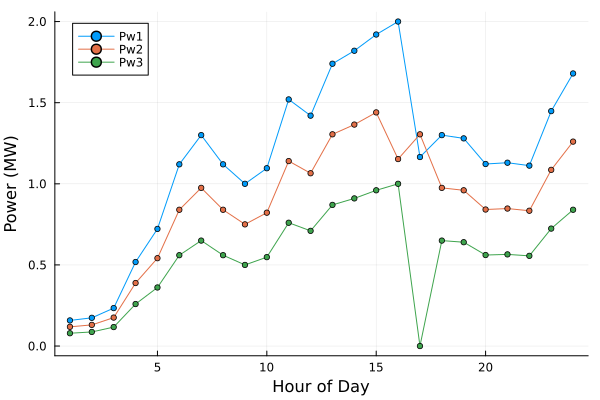

In [38]:
p2 = plot(range(1, 24, length=24), value.(model[:Pw][1,:]), marker=(:circle,3), label="Pw1")
for row in 2:size(model[:Pw])[1]
    p2 = plot!(range(1, 24, length=24), value.(model[:Pw][row,:]), marker=(:circle,3), label=f"Pw{row}")
end
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p2, layout=(2,1))

# 1.5 Multi-period optimal DC-OPF with wind and battery
n this case we consider a DC-OPF with wind and battery, over a 24-hour period. We also consider load shedding for buses.The mathematical representation of the problem is shown in the following:<br>
**Mathematical representation:**<br>
$$
\underset{}{min} \ OF = \sum_{g,t}^{} b_{g}P_{g,t} + \sum_{i,t}^{} Cls \times {LS}_{i,t} + Ccrt \times P_{i,t}^{wc}
$$
$$
\sum_{g \in \Omega_{G}^{i}}^{} P_{g,t} + {LS}_{i,t} + P_{i,t}^{w} + P_{t}^{d} = \sum_{j \in \Omega_{l}^{i}}^{} P_{ij,t} + L_{i,t} + P_{t}^{c}
$$
$$
P_{ij,t} = \frac {\delta_{i,t}-\delta_{j,t}} {X_{ij}} \; \; ij \in \Omega_{l}
$$

$$
-P_{ij}^{max} \le P_{ij,t} \le P_{ij}^{max} \; \; ij \in \Omega_{l}
$$
$$
P_{g}^{min} \le P_{g,t} \le P_{g}^{max}
$$
$$
P_{g,t} - P_{g,t-1} \le RU_{g}
$$
$$
P_{g,t-1} - P_{g,t} \le RD_{g}
$$
$$
0 \le {LS}_{i,t} \le L_{i,t}
$$
$$
P_{i,t}^{wc} = w_{t} \Lambda_{i}^{t} - P_{i,t}^{w}
$$
$$
0 \le P_{i,t}^{w} \le w_{t} \Lambda_{i}^{t}
$$
$$
SOC_{t} = SOC_{t-1} + (P_{t}^{c}\eta_{c} - P_{t}^{d}/\eta_{d})
$$
$$
P_{min}^{c} \le P_{t}^{c} \le P_{max}^{c}
$$
$$
P_{min}^{d} \le P_{t}^{d} \le P_{max}^{d}
$$
$$
SOC_{min} \le SOC_{t} \le SOC_{max}
$$
where $Cls$ is the load shedding cost, $LS$ is the amount of load shedding at each bus, $Ccrt$ is the cost of wind curtailment, $P^{wc}$ is the amount of wind curtailment, $\Omega_{G}$ is the set of generators connected to a bus, $\Omega_{l}$ are the edges of the network,  $\Lambda$ is wind availability, and $w$ is the nameplate capacity of a wind generator.

In [40]:
bus_df24[!, :omega_bt] = [[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], 
                [], [], [1], [], [2], [], [], []];

In [41]:
batt_df24 = DataFrame()
batt_df24[!, :Batt] = ["batt1", "batt2"]
batt_df24[!, :SOC0] = [40, 20]
batt_df24[!, :SOCmax] = [200, 100]
batt_df24[!, :SOCmin] = [40, 20]
batt_df24[!, :Pdmax] = [40, 20]
batt_df24[!, :Pdmin] = [0, 0]
batt_df24[!, :Pcmax] = [40, 20]
batt_df24[!, :Pcmin] = [0, 0]
batt_df24[!, :etac] = [0.95, 0.95]
batt_df24[!, :etad] = [0.90, 0.90]
batt_df24

Row,Batt,SOC0,SOCmax,SOCmin,Pdmax,Pdmin,Pcmax,Pcmin,etac,etad
,String,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Float64
1,batt1,40,200,40,40,0,40,0,0.95,0.9
2,batt2,20,100,20,20,0,20,0,0.95,0.9


In [42]:
Base.@kwdef mutable struct model_options_wind_batt_nbus
        nb::Int                               # Number of buses
        slack::Int = 1                        # Slack bus index
        g::Int = 12                           # Nmber of gas generators
        wg::Int = 3                           # Nmber of wind generators
        bt::Int = 2                           # Nmber of batteries
        t::Int = 24                           # Power Flow time horizon in hours
        Sbase::Float64 = 100                  # Power base in MVA
        b::Vector{Float64}                    # Gas generator cost coefficient
        RU::Vector{Float64}                   # Gas generator ramp-up rate
        RD::Vector{Float64}                   # Gas generator ramp-down rate
        P_min::Vector{Float64}                # Gas generator power lower bound
        P_max::Vector{Float64}                # Gas generator power upper bound
        WP_max::Vector{Float64}               # Wind generator power upper bound
        omega_g::Vector{Vector{Int}}          # List of gas generators connected to each bus
        omega_wg::Vector{Vector{Int}}         # List of wind generators connected to each bus
        omega_bt::Vector{Vector{Int}}         # List of batteries connected to each bus
        L::Vector{Float64}                    # Total daily load at each bus
        L_pct::Vector{Float64}                # Percentage of daily load at each time step
        X::Vector{Vector{Float64}}            # Reactance value for each edge
        edge_limit::Vector{Vector{Float64}}   # Power flow limit for each edge
        W::Vector{Float64}                    # Wind availability at each time step
        Cls::Float64                          # Cost of load shedding
        Ccrt::Float64                         # Cost of wind curtailment
        SOC0::Vector{Float64}                 # Battery initial state of charge
        SOCmin::Vector{Float64}               # Battery state of charge lower bound
        SOCmax::Vector{Float64}               # Battery state of charge upper bound
        Pcmin::Vector{Float64}                # Battery charge lower bound
        Pcmax::Vector{Float64}                # Battery charge upper bound
        Pdmin::Vector{Float64}                # Battery discharge lower bound
        Pdmax::Vector{Float64}                # Battery discharge upper bound
        Etac::Vector{Float64}                 # Battery charge efficiency
        Etad::Vector{Float64}                 # Battery discharge efficiency
end

model_options_wind_batt_nbus

In [43]:
function build_model_wind_nbus(opt::model_options_wind_batt_nbus)

    model = Model(GLPK.Optimizer);
    set_silent(model);
    
    #Variables
    @variable(model, Pg[g_=1:opt.g, t_=1:opt.t] >=0);                  #Generator power output
    @variable(model, P[n_=1:opt.nb, b_=1:opt.nb, t_=1:opt.t]);         #Power flow between buses
    @variable(model, delta[b_=1:opt.nb, t_=1:opt.t]);                  #Bus voltage angle
    @variable(model, Lsh[b_=1:opt.nb, t_=1:opt.t] >=0);                #Bus load shedding
    @variable(model, Pw[wg_=1:opt.wg, t_=1:opt.t] >=0);                #Wind generator power output
    @variable(model, Pwc[wg_=1:opt.wg, t_=1:opt.t] >=0);               #Wind generator power curtailment
    @variable(model, opt.SOCmin[bt_]/opt.Sbase <= SOC[bt_ = 1:opt.bt, t_=1:opt.t] <= opt.SOCmax[bt_]/opt.Sbase);   #Battery state of charge
    @variable(model, opt.Pcmin[bt_]/opt.Sbase <= Pc[bt_ = 1:opt.bt, t_=1:opt.t] <= opt.Pcmax[bt_]/opt.Sbase);      #Battery charge
    @variable(model, opt.Pdmin[bt_]/opt.Sbase <= Pd[bt_ = 1:opt.bt, t_=1:opt.t] <= opt.Pdmax[bt_]/opt.Sbase);      #Battery discharge

    #Expressions
    ex_FC = @expression(model, FC[g_= 1:opt.g, t_=1:opt.t], (opt.b[g_] * Pg[g_,t_] * opt.Sbase) );          #Fuel cost
    ex_LSHC = @expression(model, LSHC[b_= 1:opt.nb, t_=1:opt.t], (opt.Cls * Lsh[b_,t_] * opt.Sbase) );      #Load shedding cost
    ex_WCC = @expression(model, WCC[wg_= 1:opt.wg, t_=1:opt.t], (opt.Ccrt * Pwc[wg_,t_] * opt.Sbase) );     #Wind curtailment cost

    #Constraints
    c_generation_LB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Pg[g_,t_] >= opt.P_min[g_] / opt.Sbase);      #Generator min output constraint
    c_generation_UB = @constraint(model, [g_=1:opt.g, t_=1:opt.t], Pg[g_,t_] <= opt.P_max[g_] / opt.Sbase);      #Generator max output constraint
    c_ramp_up = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Pg[g_,t_] - Pg[g_,t_-1]) <= opt.RU[g_] / opt.Sbase);     #Generator ramp-up constraint
    c_ramp_down = @constraint(model, [g_=1:opt.g, t_=2:opt.t], (Pg[g_,t_-1] - Pg[g_,t_]) <= opt.RD[g_] / opt.Sbase);   #Generator ramp-down constraint

    c_reactance = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_,n_,t_] == (delta[b_,t_] - delta[n_,t_]) / opt.X[b_][n_]);
    c_slack_angle = @constraint(model, [t_=1:opt.t], delta[opt.slack,t_] == 0);
    c_edge_flow_LB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_, n_, t_] >= -opt.edge_limit[b_][n_] / opt.Sbase);
    c_edge_flow_UB = @constraint(model, [b_=1:opt.nb, n_=1:opt.nb, t_=1:opt.t], P[b_, n_, t_] <= opt.edge_limit[b_][n_] / opt.Sbase);
    c_load_shedding = @constraint(model, [b_=1:opt.nb, t_=1:opt.t], Lsh[b_,t_] <= (opt.L[b_] * opt.L_pct[t_]) / opt.Sbase);
    c_wc_balance = @constraint(model, [wg_=1:opt.wg, t_=1:opt.t], Pwc[wg_,t_] + Pw[wg_,t_] == (opt.WP_max[wg_] / opt.Sbase) * opt.W[t_]);
    c_wgen_limit = @constraint(model, [wg_=1:opt.wg, t_=1:opt.t], Pw[wg_,t_] <= (opt.WP_max[wg_] / opt.Sbase) * opt.W[t_]);
    c_SOC = @constraint(model, [bt_=1:opt.bt,t_=2:opt.t-1], SOC[bt_,t_] == SOC[bt_,t_-1] + 
        (Pc[bt_,t_] * opt.Etac[bt_]) - (Pd[bt_,t_] / opt.Etad[bt_]));
    c_SOC_0 = @constraint(model, [bt_=1:opt.bt,t_=1:1], SOC[bt_,t_] == opt.SOC0[bt_]/opt.Sbase + (Pc[bt_,t_] * opt.Etac[bt_]) - 
        (Pd[bt_,t_] / opt.Etad[bt_]));
    c_SOC_end = @constraint(model, [bt_=1:opt.bt,t_=opt.t:opt.t], SOC[bt_,t_] == opt.SOC0[bt_]/opt.Sbase);
    
    c_bus_balance = @constraint(model, [b_=1:opt.nb, t_=1:opt.t], (opt.L[b_] * opt.L_pct[t_]) / opt.Sbase == -sum(P[b_,:,t_]) + 
        sum(Pg[f,t_] for f in opt.omega_g[b_]) + Lsh[b_,t_] + sum(Pw[f,t_] for f in opt.omega_wg[b_]) - 
        sum(Pc[f,t_] for f in opt.omega_bt[b_]) + sum(Pd[f,t_] for f in opt.omega_bt[b_]) );


    #Objective Function
    @objective(model, Min, (sum(FC[:,:]) + sum(LSHC[:,:]) + sum(WCC[:,:])) );
    
    return model
end

build_model_wind_nbus (generic function with 2 methods)

In [44]:
avlblty = [0.079, 0.087, 0.117, 0.259, 0.361, 0.56, 0.65, 0.56, 0.5, 0.548, 0.76, 0.71, 0.87, 0.91, 0.96, 1., 
           0.87, 0.65, 0.64, 0.561, 0.565, 0.556, 0.724, 0.84];
demand_pcts = [0.685, 0.644, 0.613, 0.599, 0.589, 0.6, 0.63, 0.65, 0.7, 0.787, 0.84, 0.85, 0.86, 0.83, 0.81, 0.815, 
              0.87, 1., 0.99, 0.936, 0.888, 0.809, 0.746, 0.733];

In [46]:
model_options_wind_batt_24bus = model_options_wind_batt_nbus(nb=nrow(bus_df24), slack=13, g=nrow(gen_df24), wg=nrow(wg_df), bt=nrow(batt_df24), t=24, 
    b=gen_df24[!, :b_g], RU=gen_df24[!, :RU], RD=gen_df24[!, :RD], P_min=gen_df24[!, :P_min], P_max=gen_df24[!, :P_max], 
    WP_max=wg_df[!, :cap], omega_g=bus_df24[!, :omega_g], omega_wg=bus_df24[!, :wind_gen], omega_bt=bus_df24[!, :omega_bt], 
    L=bus_df24[!, :demands], L_pct=demand_pcts, X=bus_df24[!, :x], edge_limit=bus_df24[!, :limit], W=avlblty, Cls=10000, Ccrt=50, 
    SOC0=batt_df24[!, :SOC0], SOCmax=batt_df24[!, :SOCmax], SOCmin=batt_df24[!, :SOCmin], Pcmax=batt_df24[!, :Pcmax], 
    Pcmin=batt_df24[!, :Pcmin], Pdmax=batt_df24[!, :Pdmax], Pdmin=batt_df24[!, :Pdmin], Etac=batt_df24[!, :etac], Etad=batt_df24[!, :etad]);

model = build_model_wind_nbus(model_options_wind_batt_24bus);
optimize!(model)

println("Total operating cost is \$", round(objective_value(model), digits=2))

Total operating cost is $419558.77


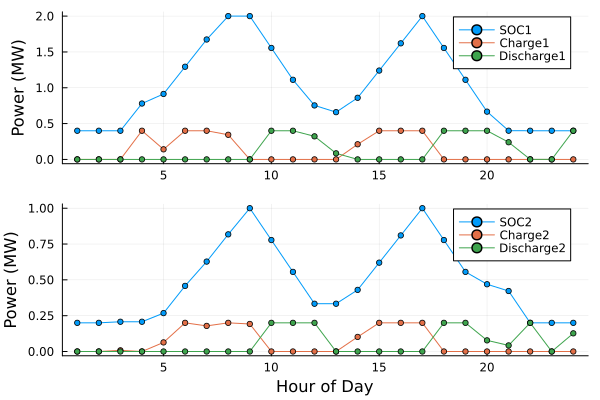

In [47]:
p1 = plot(range(1, 24, length=24), value.(model[:SOC][1,:]), marker=(:circle,3), label="SOC1")
p1 = plot!(range(1, 24, length=24), value.(model[:Pc][1,:]), marker=(:circle,3), label="Charge1")
p1 = plot!(range(1, 24, length=24), value.(model[:Pd][1,:]), marker=(:circle,3), label="Discharge1")
yaxis!("Power (MW)")

p2 = plot(range(1, 24, length=24), value.(model[:SOC][2,:]), marker=(:circle,3), label="SOC2")
p2 = plot!(range(1, 24, length=24), value.(model[:Pc][2,:]), marker=(:circle,3), label="Charge2")
p2 = plot!(range(1, 24, length=24), value.(model[:Pd][2,:]), marker=(:circle,3), label="Discharge2")
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p1, p2, layout=(2,1))

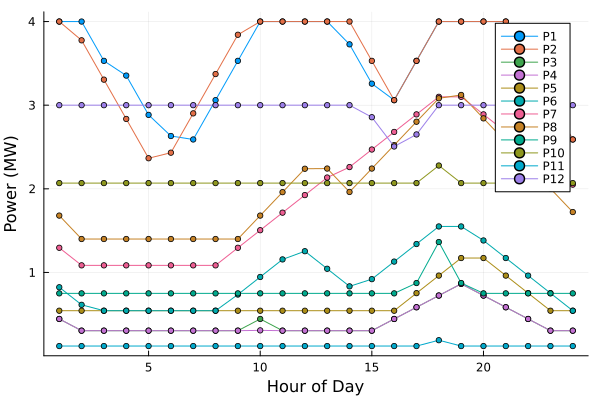

In [48]:
p = plot(range(1, 24, length=24), value.(model[:Pg][1,:]), marker=(:circle,3), label="P1")
for row in 2:size(model[:Pg])[1]
    p = plot!(range(1, 24, length=24), value.(model[:Pg][row,:]), marker=(:circle,3), label=f"P{row}")
end
xaxis!("Hour of Day")
yaxis!("Power (MW)")
plot(p, layout=(1,1))

# References
1. Soroudi, Alireza. Power system optimization modeling in GAMS. Vol. 78. Berlin/Heidelberg, Germany: Springer, 2017.
2. https://github.com/Power-Systems-Optimization-Course/power-systems-optimization/blob/master/Notebooks/06-Optimal-Power-Flow.ipynb
3. Li F, Bo R. Small test systems for power system economic studies. InIEEE PES general meeting 2010 Jul 25 (pp. 1-4). IEEE.
4. Ordoudis C, Pinson P, Morales JM, Zugno M. An updated version of the IEEE RTS 24-bus system for electricity market and power system operation studies. Technical University of Denmark. 2016;13